In [191]:
import os
import getpass

from utils import *
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import pickle

plt.style.use('ggplot')

In [192]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [193]:
train_images_filenames = pickle.load(open('../train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('../test_images_filenames.dat','rb'))
train_images_filenames = ['../..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['../..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('../train_labels.dat','rb'))
test_labels = pickle.load(open('../test_labels.dat','rb'))

# Model Training

In [194]:
TRAIN = True
#user defined variables
IMG_SIZE    = 64
BATCH_SIZE  = 256
EPOCHS = 50

#DATASET_DIR = '/home/mcv/datasets/MIT_split'
#MODEL_FNAME = '/home/group01/work/my_first_mlp.h5'
DATASET_DIR = '../../MIT_split'
MODEL_FNAME = '../../my_first_mlp.h5'

In [195]:
if not os.path.exists(DATASET_DIR):
  print(Color.RED, 'ERROR: dataset directory '+DATASET_DIR+' do not exists!\n')

In [196]:
if TRAIN:
    print('Building MLP model...\n')

    #Build the Multi Layer Perceptron model
    model = Sequential()
    model.add(Reshape((IMG_SIZE*IMG_SIZE*3,), input_shape=(IMG_SIZE, IMG_SIZE, 3), name='first'))
    model.add(Dense(units=2048, activation='relu',name='second'))
    model.add(Dense(units=1024, activation='relu', name='third'))
    model.add(Dense(units=512, activation='relu', name='fourth'))
    model.add(Dense(units=258, activation='relu', name='fifth'))
    model.add(Dense(units=8, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])

    print(model.summary())
    #plot_model(model, to_file='modelMLP.png', show_shapes=True, show_layer_names=True)

    print('Done!\n')

Building MLP model...

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first (Reshape)             (None, 12288)             0         
                                                                 
 second (Dense)              (None, 2048)              25167872  
                                                                 
 third (Dense)               (None, 1024)              2098176   
                                                                 
 fourth (Dense)              (None, 512)               524800    
                                                                 
 fifth (Dense)               (None, 258)               132354    
                                                                 
 dense_13 (Dense)            (None, 8)                 2072      
                                                                 
Total params: 27,925,274
Train

In [197]:
if TRAIN:
    if os.path.exists(MODEL_FNAME):
        print('WARNING: model file '+MODEL_FNAME+' exists and will be overwritten!\n')
        #model.load_weights(MODEL_FNAME)

    print('Start training...\n')

    # this is the dataset configuration we will use for training
    # only rescaling
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True)

    # this is the dataset configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            DATASET_DIR+'/train',  # this is the target directory
            target_size=(IMG_SIZE, IMG_SIZE),  # all images will be resized to IMG_SIZExIMG_SIZE
            batch_size=BATCH_SIZE,
            classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
            class_mode='categorical')  # since we use binary_crossentropy loss, we need categorical labels

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            DATASET_DIR+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
            class_mode='categorical')

    history = model.fit(
            train_generator,
            steps_per_epoch=1881 // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=validation_generator,
            validation_steps=807 // BATCH_SIZE)

    print('Done!\n')
    print('Saving the model into '+MODEL_FNAME+' \n')
    model.save_weights(MODEL_FNAME)  # always save your weights after training or during training
    print('Done!\n')


Start training...

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Epoch 1/50
7/7 [==============================] - 2s 324ms/step - loss: 1.2078 - accuracy: 0.5975 - val_loss: 1.6108 - val_accuracy: 0.4167
Epoch 2/50
7/7 [==============================] - 2s 258ms/step - loss: 1.2093 - accuracy: 0.5834 - val_loss: 1.3074 - val_accuracy: 0.5286
Epoch 3/50
7/7 [==============================] - 2s 281ms/step - loss: 1.2026 - accuracy: 0.5938 - val_loss: 1.2724 - val_accuracy: 0.5560
Epoch 4/50
7/7 [==============================] - 2s 267ms/step - loss: 1.1493 - accuracy: 0.6148 - val_loss: 1.3224 - val_accuracy: 0.5182
Epoch 5/50
7/7 [==============================] - 2s 274ms/step - loss: 1.1704 - accuracy: 0.6074 - val_loss: 1.2483 - val_accuracy: 0.5729
Epoch 6/50
7/7 [==============================] - 2s 268ms/step - loss: 1.1010 - accuracy: 0.6369 - val_loss: 1.4061 - val_accuracy: 0.5273
Epoch 7/50
7/7 [==============================] - 2s 276m

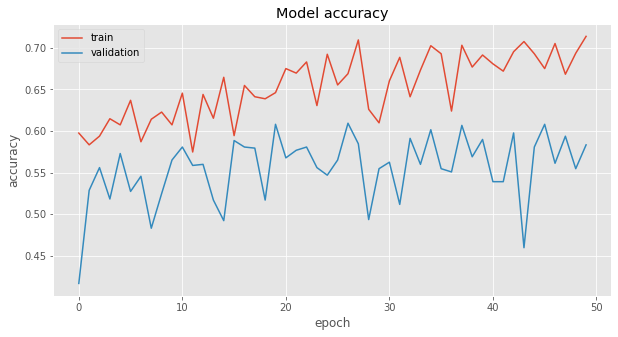

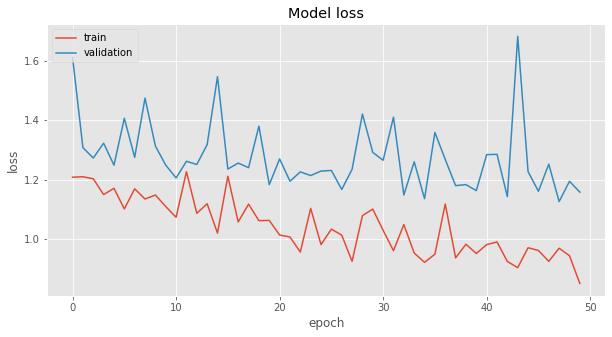

In [198]:
if TRAIN:
    # summarize history for accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('accuracy.jpg')
    #plt.close()
    # summarize history for loss
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('loss.jpg')

# Analysis

## Trained models against previous techniques

___

Here we will compare the performances of an end-to-end MLP against the performances of a SVM classifier trained on the features learned by this same MLP.

### End to end Multi-Layer Perceptron

After training a Neural Network with the code above, we will benchmark the performances of this model on our test dataset.

In [201]:
#Build the Multi Layer Perceptron model
IMG_SIZE = 128
model = Sequential()
model.add(Reshape((IMG_SIZE*IMG_SIZE*3,), input_shape=(IMG_SIZE, IMG_SIZE, 3), name='first'))
model.add(Dense(units=2048, activation='relu',name='second'))
model.add(Dense(units=1024, activation='relu', name='third'))
model.add(Dense(units=512, activation='relu', name='fourth'))
model.add(Dense(units=258, activation='relu', name='fifth'))
model.add(Dense(units=8, activation='softmax'))

In [202]:
#Load Model Weight
MODEL_LOAD_NAME = '../../my_first_mlp_128x128_150epoch.h5'
model.load_weights(MODEL_LOAD_NAME)

In [203]:
directory = DATASET_DIR+'/test'
classes = {'coast':0,'forest':1,'highway':2,'inside_city':3,'mountain':4,'Opencountry':5,'street':6,'tallbuilding':7}
correct = 0
total   = 807
count   = 0

for imname, label in zip(test_images_filenames, test_labels):
    im = np.asarray(Image.open(os.path.join(imname)))
    im = np.expand_dims(cv2.resize(im, (IMG_SIZE, IMG_SIZE)), axis=0)
    cls = classes[label]
    out = model.predict(im)
    predicted_cls = np.argmax( out )
    if predicted_cls == cls:
        correct+=1
    count += 1
    print('Evaluated images: '+str(count)+' / '+str(total), end='\r')
    
colorprint(Color.BLUE, 'Done!\n')
colorprint(Color.GREEN, 'Test Acc. = '+str(correct/total)+'\n')

Done!images: 807 / 807
Test Acc. = 0.6468401486988847


### SVM Classifier with learnt features

In [204]:
model_layer = Model(inputs=model.input, outputs=model.get_layer('fourth').output)
layer_preds = []
layer_classes = []

In [205]:
if not os.path.exists("train_layer_preds.pkl"):

    #We will start by creating features training sets
    count, total = 0, 1881

    for imname, label in zip(train_images_filenames, train_labels):
        im = np.asarray(Image.open(os.path.join(imname)))
        im = np.expand_dims(cv2.resize(im, (IMG_SIZE, IMG_SIZE)), axis=0)
        cls = classes[label]

        layer_preds.append(model_layer.predict(im))
        layer_classes.append(cls)
    
        count += 1
        print('Added images: '+ str(count)+' / '+str(total), end='\r')

    X_train = np.vstack(layer_preds)
    y_train = np.array(layer_classes)
    
    with open("train_layer_preds.pkl", "wb") as f: 
        pickle.dump(layer_preds, f)
    with open("train_layer_preds_classes.pkl", "wb") as f:
        pickle.dump(layer_classes, f)

else:
    X_train = pickle.load(open("train_layer_preds.pkl","rb"))
    y_train = pickle.load(open("train_layer_preds_classes.pkl","rb"))


In [206]:

if not os.path.exists("test_layer_preds.pkl"):

    layer_preds = []
    layer_classes = []

    #We will start by creating features training sets
    count, total = 0, 807

    for imname, label in zip(test_images_filenames, test_labels):
        im = np.asarray(Image.open(os.path.join(imname)))
        im = np.expand_dims(cv2.resize(im, (IMG_SIZE, IMG_SIZE)), axis=0)
        cls = classes[label]

        layer_preds.append(model_layer.predict(im))
        layer_classes.append(cls)
    
        count += 1
        print('Added images: '+ str(count)+' / '+str(total), end='\r')

    X_test = np.vstack(layer_preds)
    y_test = np.array(layer_classes)
    
    with open("test_layer_preds.pkl", "wb") as f: 
        pickle.dump(layer_preds, f)
    with open("test_layer_preds_classes.pkl", "wb") as f:
        pickle.dump(layer_classes, f)

else:
    X_test = pickle.load(open("test_layer_preds.pkl","rb"))
    y_test = pickle.load(open("test_layer_preds_classes.pkl","rb"))

In [209]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#Define SVM Model and scaler
svm_model = svm.SVC()
scaler = StandardScaler()

scaler.fit_transform(X_train)
scaler.transform(X_test)

#Fit the SVM model to the training data
svm_model.fit(X_train, y_train)

#Get the predictions for the training and test sets
svm_train_preds = svm_model.predict(X_train)
svm_test_preds = svm_model.predict(X_test)

#Get accuracy score
colorprint(Color.GREEN, f"Accuracy on the training set : {round(accuracy_score(y_train, svm_train_preds),3)} \n")
colorprint(Color.BLUE , f"Accuracy on the test set : {round(accuracy_score(y_test, svm_test_preds),3)}")


Accuracy on the training set : 0.965 
Accuracy on the test set : 0.674